In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Intro

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
%matplotlib inline

In [4]:
!pip install torchsummary

In [5]:
from IPython.core.display import display, HTML, Javascript

color_map = ['#FFFFFF','#FF5733']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = '''
div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s;
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5);
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s;
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s;
    border-top: 2px solid %s;
}

div.input_prompt {
color: %s;
}

div.output_prompt {
color: %s; 
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s;
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s;
}

.edit_mode div.cell.selected:before {
background: %s;
}

.edit_mode div.cell.selected {
border-color: %s;

}
'''

def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, 
                                            main_color,  main_color, prompt, main_color, main_color, 
                                            main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

/tmp/ipykernel_34/2598556545.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [6]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [7]:
api_token = {"username":"polskyyyyy","key":"305c7e2bfdfeca4cfd88e36ed61390a7"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
    

In [8]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c generated-or-not
!unzip generated-or-not.zip

 98%|████████████████████████████████████████▎| 341M/346M [00:03<00:00, 141MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:03<00:00, 108MB/s]
Archive:  generated-or-not.zip
  inflating: images/01SPjdJuM4.jpg   
  inflating: images/01a7MiLURN.jpg   
  inflating: images/05q5J7VWr4.png   
  inflating: images/0666kmCAAC.jpeg  
  inflating: images/07aHL0dVg4.jpg   
  inflating: images/09Egy0VfTa.jpeg  
  inflating: images/0HBgVT0VvK.png   
  inflating: images/0IE6GFg13M.jpg   
  inflating: images/0OOMZGDyV8.jpg   
  inflating: images/0R1JRbHS33.jpeg  
  inflating: images/0SSwUAl04C.png   
  inflating: images/0XXH9LDP1C.jpg   
  inflating: images/0XbpHcAqVo.jpg   
  inflating: images/0XftCQbfAl.jpg   
  inflating: images/0Y1MAVdEa5.jpg   
  inflating: images/0a1KuiILS4.jpg   
  inflating: images/0aj2WnLarN.jpg   
  inflating: images/0bAvf1FcUP.jpeg  
  inflating: images/0fNsR1ONLv.jpg   
  inflating: images/0gbbtcW2lP.jpg   
  inflating: images/0kX8W174U6.png   
  inflati

# Dataset

In [9]:
train_df = pd.read_csv('/kaggle/working/train.csv')
test_df = pd.read_csv('/kaggle/working/test.csv')

In [10]:
print('train dataframe:', train_df.head().to_markdown(), sep='\n')
print()
print('test dataframe:', test_df.head().to_markdown(), sep='\n')

train dataframe:
|    | id              |   target |
|---:|:----------------|---------:|
|  0 | gL5fWrgNPU.jpg  |        0 |
|  1 | KKWXJDN8uM.png  |        1 |
|  2 | Wb2I0CXlAY.jpg  |        0 |
|  3 | G7PLhKpaf7.jpeg |        1 |
|  4 | DEUkeefz6Z.jpg  |        0 |

test dataframe:
|    | id              |
|---:|:----------------|
|  0 | Qt1fGUB0Vz.jpeg |
|  1 | j4Rhioq7R3.jpeg |
|  2 | rD0hgFHJUZ.jpeg |
|  3 | aY5z1EJsJ6.jpeg |
|  4 | qZ3IoxD2TE.jpeg |


In [11]:
train_df.shape, test_df.shape

((1012, 2), (506, 1))

In [12]:
train_df[train_df.duplicated(keep=False)]

,id,target


In [13]:
test_df[test_df.duplicated(keep=False)]

,id


In [14]:
train_df['target'].value_counts()

target
0    667
1    345
Name: count, dtype: int64

In [15]:
source_dir = 'images'
output_dir = 'converted_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)
    
    try:
        with Image.open(file_path) as img:
            output_file = os.path.splitext(file_name)[0] + '.jpg'
            output_path = os.path.join(output_dir, output_file)
            
            img.convert('RGB').save(output_path, 'JPEG')
    except IOError:
        print(f'file {file_name} should not be concidered as image')

In [16]:
train_df['id'] = train_df['id'].apply(lambda x: x[:10] + '.jpg')
test_df['id'] = test_df['id'].apply(lambda x: x[:10] + '.jpg')

In [17]:
imgpath = '/kaggle/working/converted_images'

generated = train_df.loc[train_df['target']==1]['id'].values    
not_generated = train_df.loc[train_df['target']==0]['id'].values

print('generated img')
print(generated[0:3],'\n')

print('not_generated img')
print(not_generated[0:3])

generated img
['KKWXJDN8uM.jpg' 'G7PLhKpaf7.jpg' 'hG9nlBfDeh.jpg'] 

not_generated img
['gL5fWrgNPU.jpg' 'Wb2I0CXlAY.jpg' 'DEUkeefz6Z.jpg']


In [18]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j)
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

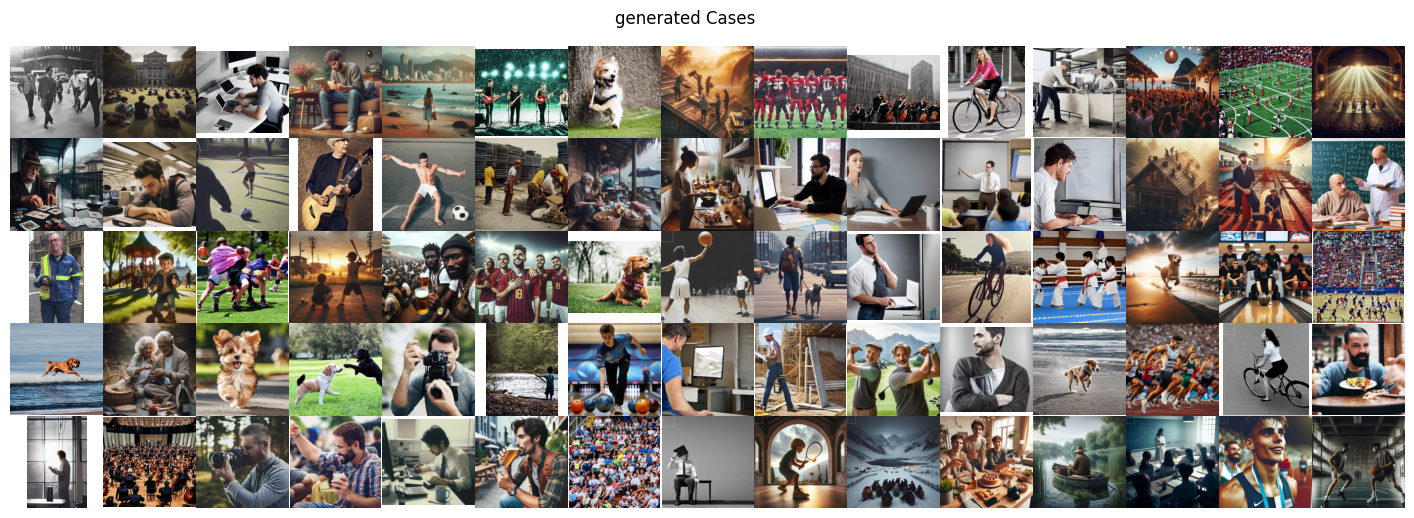

In [19]:
plot_fig(generated,'generated Cases')

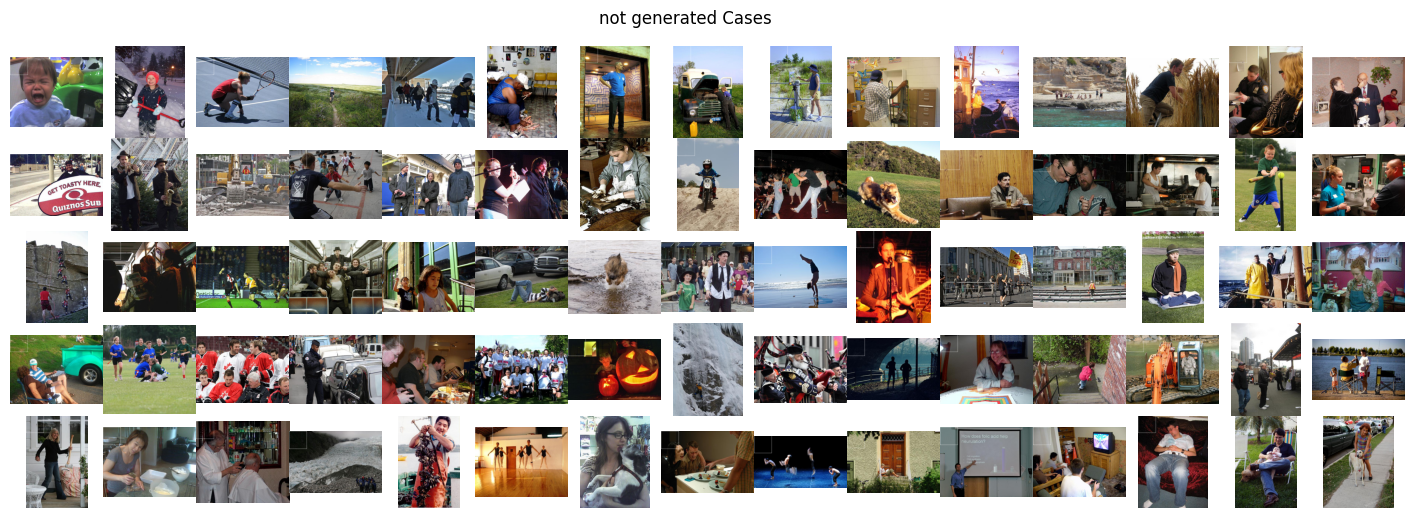

In [20]:
plot_fig(not_generated,'not generated Cases')

# Data Preparation

In [31]:
torch.manual_seed(0)

class pytorch_data(Dataset):
    def __init__(self,csv_file, image_dir, transform):
        self.img_target = csv_file
        self.img_dir = image_dir
        self.transform = transform
        self.has_target = 'target' in self.img_target.columns
        
    def __len__(self):
        return len(self.img_target)
    
    def __getitem__(self, idx):
        img_id = self.img_target.iloc[idx, 0]
        img_name = os.path.join(self.img_dir, img_id)
        image = Image.open(img_name)
        
        if self.has_target:
            target = self.img_target.iloc[idx, 1]
        else:
            target = None
            
        image = self.transform(image)
        
        if self.has_target:
            return image, target
        else:
            return image

In [32]:
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46), antialias=True)])

In [33]:
type(train_df)

pandas.core.frame.DataFrame

In [34]:
train_dataset = pytorch_data(train_df, imgpath, data_transformer)
test_dataset = pytorch_data(test_df, imgpath, data_transformer)

In [35]:
image,target=train_dataset[10]
print(image.shape,torch.min(image),torch.max(image))

torch.Size([3, 46, 46]) tensor(0.0609) tensor(0.9174)


In [140]:
image=test_dataset[10]
print(image.shape,torch.min(image),torch.max(image))

torch.Size([3, 40, 40]) tensor(0.0039) tensor(1.)


In [97]:
len_img=len(train_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(train_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 809
validation dataset size: 203


In [98]:
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 0
torch.Size([3, 40, 40]) 1


In [99]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [100]:
# Create grid of sample images 
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')

image indices: [427 208 708 128 504 261 457 741 690  78 474 349  59 781 540 108 779 366
  33 489 629 714 404 136 446 268 787 152 691 452]
torch.Size([3, 128, 422])


In [101]:
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

image indices: [ 61  86 200  45 192  30   6 168   9 188  60 149  61  48  27  76 174 166
 116  17  81 140  62  27  14 195  83  68 114  99]
torch.Size([3, 128, 422])


# Image Augmentation Definitions

In [103]:
tr_transf = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [104]:
val_transf = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [105]:
# The subset can also have transform attribute (if we asign)
train_ts.transform

Compose(
    Resize(size=(40, 40), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

# Creating Dataloaders

In [106]:
# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [107]:
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 40, 40]) tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1])


In [108]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 1, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [109]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [110]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [111]:
loss_func = nn.NLLLoss(reduction="sum")

In [112]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [113]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}

In [114]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [115]:
''' Helper Functions'''

# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [116]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

Text(0.5, 1.0, 'Convergence History')

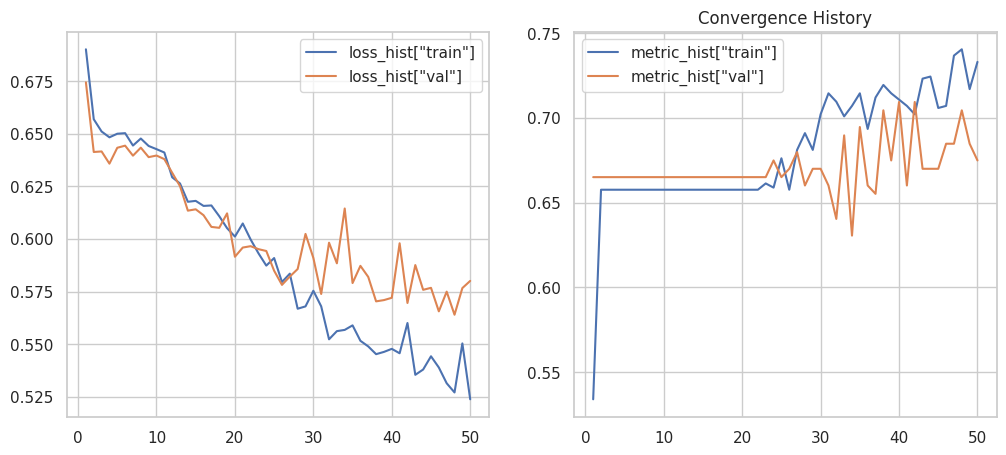

In [117]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

In [171]:
cnn_model.eval()  # Переключаем модель в режим оценки
predictions = []
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


with torch.no_grad():  # Отключаем вычисление градиентов
    for inputs in tqdm(test_loader, total=len(test_loader)):
        inputs = inputs.to(device)  # Перемещаем входные данные на устройство

        # Выполняем прямое распространение через модель
        outputs = model(inputs.float())

        # Применяем софтмакс для получения вероятностей
        probs = torch.softmax(outputs, dim=1)

        # Собираем вероятности для интересующего нас класса (например, индекс 1 для класса "сгенерировано")
        predictions.extend(probs[:, 1].cpu().numpy())

  0%|          | 0/32 [00:00<?, ?it/s]

In [172]:
submission = pd.read_csv('/kaggle/working/sample_submission.csv')
submission.to_csv('submission.csv',index=False)